#CNN/LSTM model

In [5]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from torch.utils.data import DataLoader
import time

Dowload data

In [3]:
drive.mount('/content/gdrive')

#import time series
sp500_data = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/sp500_data.csv', index_col=0)
sp500_data = sp500_data.iloc[2:] #remove the first 2 rows that don't contain the time series
sp500_data.index.name = 'Date'
sp500_data.index = pd.to_datetime(sp500_data.index)

#save Close price and Log Returns into a pd.Series
Close_price = sp500_data['Close'].copy().astype(float)
Log_return = sp500_data['Log Return'].copy().astype(float)

#drop columns not needed
sp500_data.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)


# #import ARIMA residuals
# residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/close_price_residuals.csv', index_col=0)
# sp500_data.insert(0, 'Residuals', residuals.values)

# #import ARIMA fitted values (predictions on the training set)
# fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/fitted_values.csv', index_col=0)

# #import ARIMA predictions on the test set
# ARIMA_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/arima_predictions.csv', index_col=0).squeeze() #to read it as a pd.Series
# ARIMA_predictions.index = pd.to_datetime(ARIMA_predictions.index)


#import SARIMA residuals
residuals = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_residuals.csv', index_col=0, sep=";")
residuals.index = pd.to_datetime(residuals.index, format = "%d/%m/%Y")

#import SARIMA fitted values (predictions on the training set)
SARIMA_fitted_values = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_fitted_values.csv', index_col=0)
SARIMA_fitted_values.index = pd.to_datetime(SARIMA_fitted_values.index)

#import SARIMA predictions on the test set
SARIMA_test_predictions = pd.read_csv('/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
SARIMA_test_predictions.index = pd.to_datetime(SARIMA_test_predictions.index)

Mounted at /content/gdrive


##Helper functions to move data to the GPU

In [4]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in iter(self.dl):
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Univariate sliding windows

In [6]:
#univariate sliding window
train_data = residuals.loc[: '2018']
train_data.index = pd.to_datetime(train_data.index)

val_data = residuals.loc['2019': '2021']
val_data.index = pd.to_datetime(val_data.index)

train_val_data = residuals.loc[: '2021']
train_val_data.index = pd.to_datetime(train_val_data.index)

test_data = residuals.loc['2022':]
test_data.index = pd.to_datetime(test_data.index)

extended_test_data = pd.concat([train_val_data.iloc[-10:, 0], test_data], axis=0)
extended_test_data.index = pd.concat([train_val_data.iloc[-10:, 0], test_data], axis=0).index

# scaler = StandardScaler()
# scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
scaler = RobustScaler()
train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data.values.reshape(-1, 1)))
val_data_scaled = pd.DataFrame(scaler.transform(val_data.values.reshape(-1, 1)))
train_val_data_scaled = pd.DataFrame(scaler.fit_transform(train_val_data.values.reshape(-1, 1)))
test_data_scaled = pd.DataFrame(scaler.transform(test_data.values.reshape(-1, 1)))
extended_test_data_scaled = pd.DataFrame(scaler.transform(extended_test_data.values.reshape(-1, 1)))


def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
      _x = data.iloc[i:i+seq_length]
      _y = data.iloc[i + seq_length]
      X.append(_x)
      y.append(_y)

    return np.array(X), np.array(y)


#sliding windows
X_train, y_train  = sliding_windows(train_data_scaled, 10)
X_val, y_val= sliding_windows(val_data_scaled, 10)
X_test, y_test = sliding_windows(test_data_scaled, 10)
X_train_val , y_train_val = sliding_windows(train_val_data_scaled, 10)
X_test_extended, y_test_extended = sliding_windows(extended_test_data_scaled, 10)

Covert data into tensor

In [7]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


#istance of the custom dataset class
train_df = Custom_df(X_train, y_train)
val_df = Custom_df(X_val, y_val)
train_val_df = Custom_df(X_train_val, y_train_val)
test_df = Custom_df(X_test, y_test)
test_extended_df = Custom_df(X_test_extended, y_test_extended)


#create dataloaders (to perform training/inference in batch)
batch_size = 128
num_workers = 2

train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
test_extended_loader = DataLoader(test_extended_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


#get device
device = get_device()


#move to device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
train_val_loader = DeviceDataLoader(train_val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)
test_extended_loader = DeviceDataLoader(test_extended_loader, device)

##Neural network models

LSTM followed by CNN

In [8]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

LSTM_CNN_model = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
LSTM_CNN_model.to(device) #move the istance to the device

LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

CNN + LSTM parallel architecture

In [9]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

parallelCNNLSTM_model = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
parallelCNNLSTM_model.to(device) #move the istance to the device

ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [10]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 3

LSTM_model = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
LSTM_model.to(device) #move the istance to the device

LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

CNN model

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
num_classes = 1 # regression
# input_size = 32  # Number of features per time step
input_size = 1 #number of input features
hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
num_layers = 1

CNN_model = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
CNN_model.to(device) #move the istance to the device

CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

##Training

In [12]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    # best_val_loss = float('inf') #initialized to the largest possible value
    # no_improve_count = 0  # Count epochs with no improvement in validation loss

    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        #scheduler.step(result['val_loss'])

        # if result['val_loss'] < best_val_loss:
        #     best_val_loss = result['val_loss']
        #     print(f"best vall loss: {best_val_loss}")
        #     no_improve_count = 0  # Reset counter on improvement
        # else:
        #     print(f"No improvement , current val loss: {result['val_loss']} best loss: {best_val_loss}")
        #     no_improve_count += 1  # Increment counter if no improvement


        model.epoch_end(epoch, result) #print results
        history.append(result)

        # if no_improve_count >= 50:
        #     print(f"No improvement in validation loss for {no_improve_count} epochs. Stopping training.")
        #     break

    return history

Train a single NN

warmup phase
Epoch [0], last_lr: 0.00004, train_loss: 0.3573, val_loss: 0.3611
Epoch [1], last_lr: 0.00006, train_loss: 0.2772, val_loss: 0.2764
Epoch [2], last_lr: 0.00008, train_loss: 0.1554, val_loss: 0.1732
Epoch [3], last_lr: 0.00010, train_loss: 0.0519, val_loss: 0.1216
Epoch [4], last_lr: 0.00012, train_loss: 0.0203, val_loss: 0.0768
Epoch [5], last_lr: 0.00014, train_loss: 0.0107, val_loss: 0.0567
Epoch [6], last_lr: 0.00016, train_loss: 0.0077, val_loss: 0.0479
Epoch [7], last_lr: 0.00018, train_loss: 0.0067, val_loss: 0.0416
Epoch [8], last_lr: 0.00020, train_loss: 0.0061, val_loss: 0.0366
Epoch [9], last_lr: 0.00022, train_loss: 0.0058, val_loss: 0.0329
Epoch [10], last_lr: 0.00024, train_loss: 0.0056, val_loss: 0.0301
Epoch [11], last_lr: 0.00026, train_loss: 0.0054, val_loss: 0.0283
Epoch [12], last_lr: 0.00028, train_loss: 0.0054, val_loss: 0.0269
Epoch [13], last_lr: 0.00030, train_loss: 0.0054, val_loss: 0.0265
Epoch [14], last_lr: 0.00032, train_loss: 0.0055, val_loss:

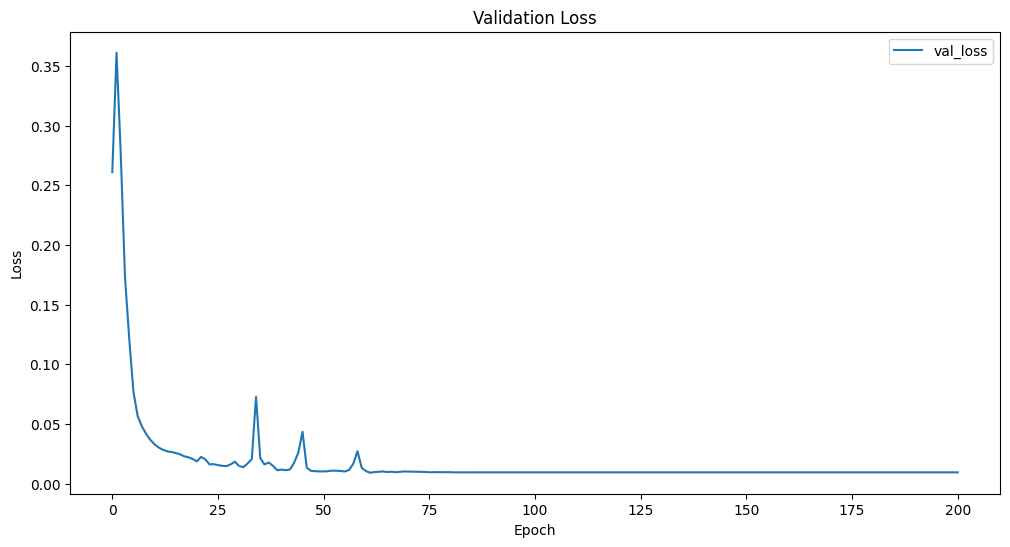

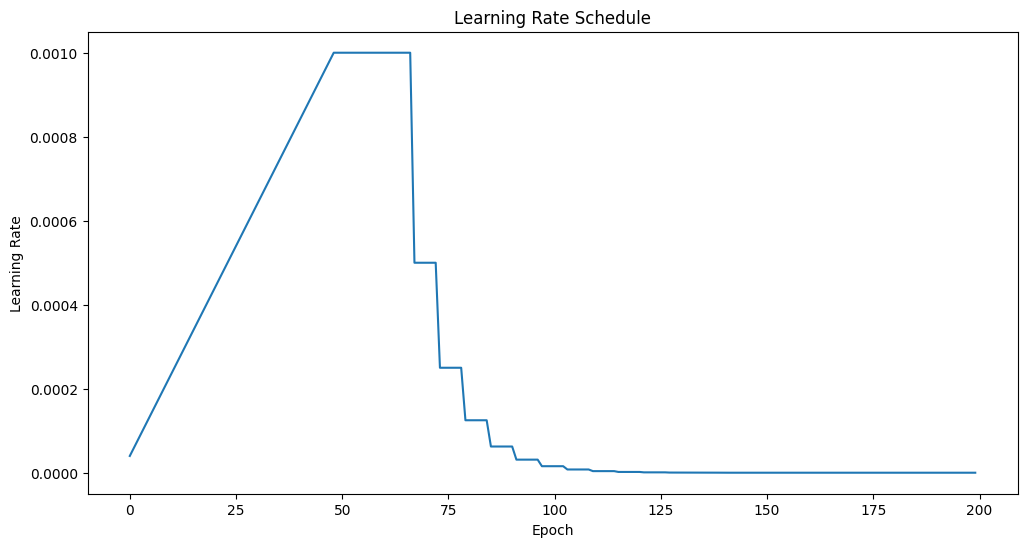

In [71]:
#evaluate untrained model
history = [evaluate(CNN_model, test_loader)]


#train model
epochs = 200
warmup_epochs = 50
max_lr = 0.001
grad_clip = None
weight_decay = 1e-5
opt_func = torch.optim.Adam


start_time = time.time()
history += fit(epochs, max_lr, CNN_model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")


#visualize val_loss
plt.figure(figsize=(12, 6))
val_loss = [x['val_loss'] for x in history]
# train_loss = [x['train_loss'] for x in history[1:]]
plt.plot(val_loss)
# plt.plot(train_loss)
plt.legend(['val_loss', 'train_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()


plt.figure(figsize=(12, 6))
lr = [x['lrs'] for x in history[1:]]
plt.plot(lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.show()

Train all the NN models at once

training model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.3013, val_loss: 0.3183
Epoch [1], last_lr: 0.00010, train_loss: 0.1750, val_loss: 0.2132
Epoch [2], last_lr: 0.00013, train_loss: 0.1493, val_loss: 0.1859
Epoch [3], last_lr: 0.00017, train_loss: 0.1178, val_loss: 0.1709
Epoch [4], last_lr: 0.00020, train_loss: 0.0900, val_loss: 0.1346
Epoch [5], last_lr: 0.00023, train_loss: 0.0445, val_loss: 0.0742
Epoch [6], last_lr: 0.00027, train_loss: 0.0195, val_loss: 0.0581
Epoch [7], last_lr: 0.00030, train_loss: 0.0230, val_loss: 0.0556
Epoch [8], last_lr: 0.00033, train_loss: 0.0267, val_loss: 0.0603
Epoch [9], last_lr: 0.00037, train_loss: 0.0320, val_loss

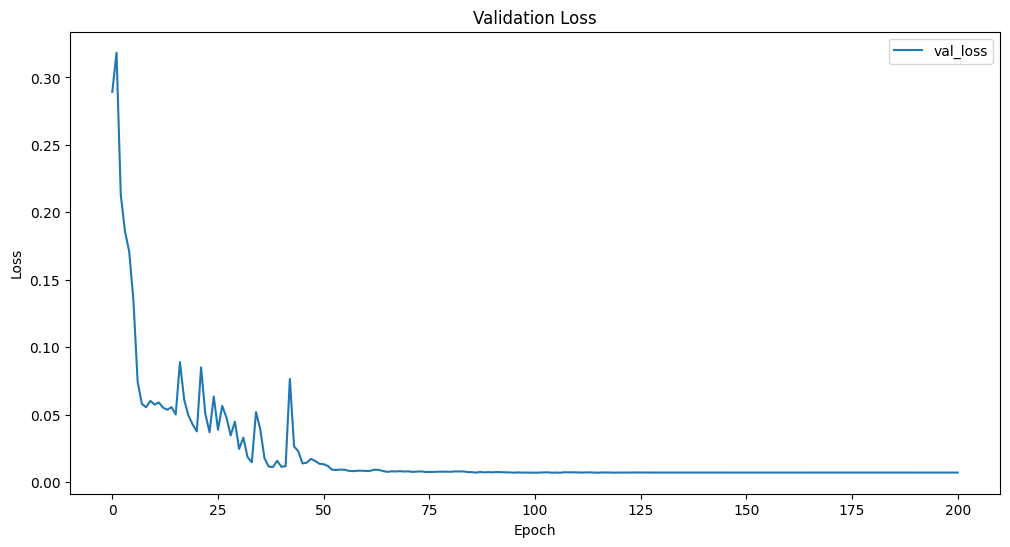

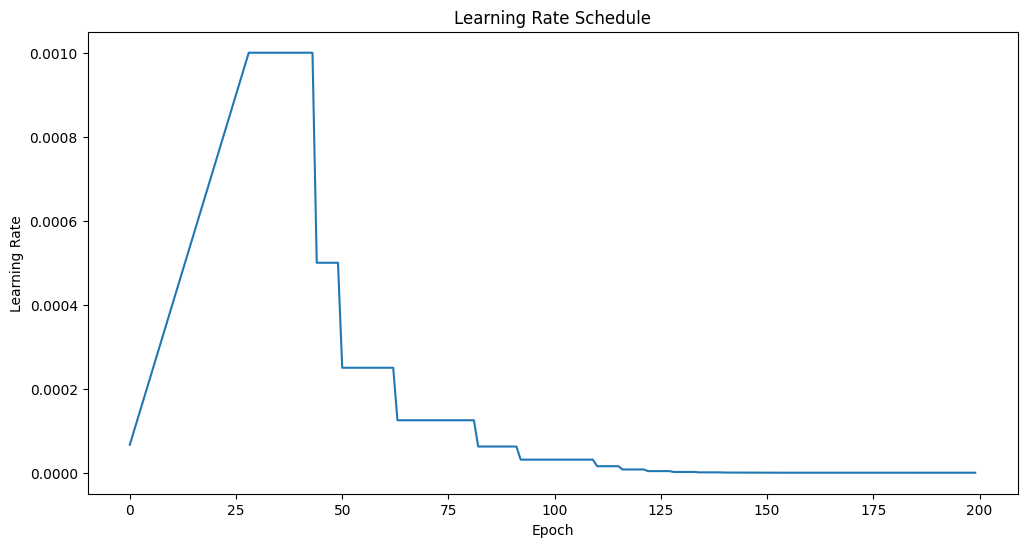

training model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00005, train_loss: 0.2586, val_loss: 0.2736
Epoch [1], last_lr: 0.00007, train_loss: 0.1691, val_loss: 0.1911
Epoch [2], last_lr: 0.00010, train_loss: 0.0752, val_loss: 0.1268
Epoch [3], last_lr: 0.00013, train_loss: 0.0303, val_loss: 0.0815
Epoch [4], last_lr: 0.00015, train_loss: 0.0146, val_loss: 0.0503
Epoch [5], last_lr: 0.00017, train_loss: 0.0080, val_loss: 0.0406
Epoch [6], last_lr: 0.00

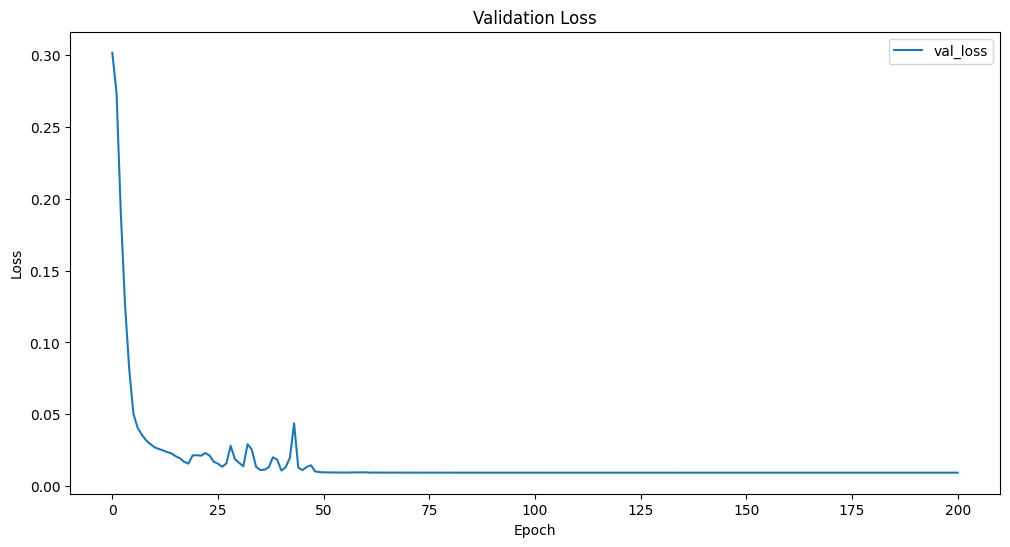

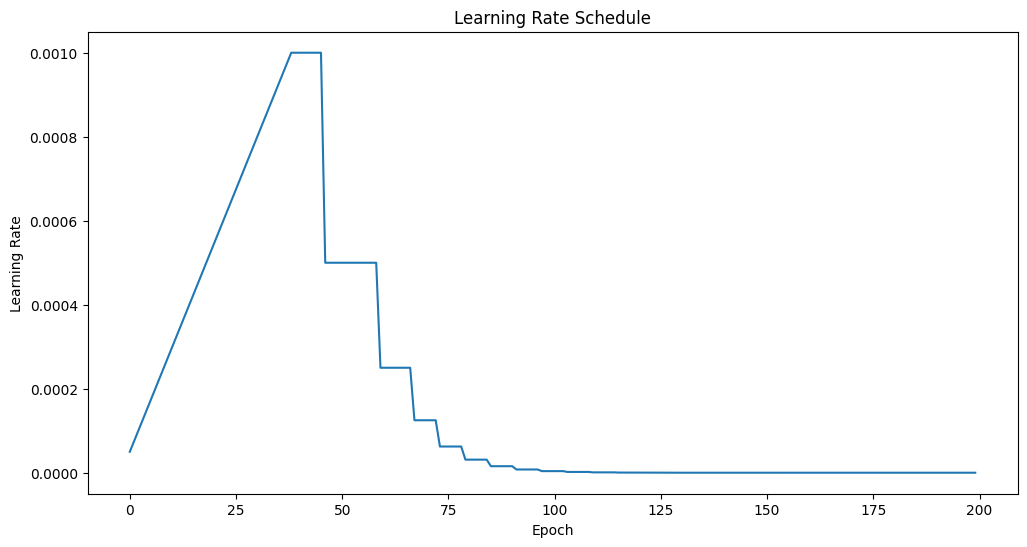

training model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00010, train_loss: 0.1880, val_loss: 0.1824
Epoch [1], last_lr: 0.00015, train_loss: 0.0616, val_loss: 0.1240
Epoch [2], last_lr: 0.00020, train_loss: 0.0383, val_loss: 0.0773
Epoch [3], last_lr: 0.00025, train_loss: 0.0178, val_loss: 0.0484
Epoch [4], last_lr: 0.00030, train_l

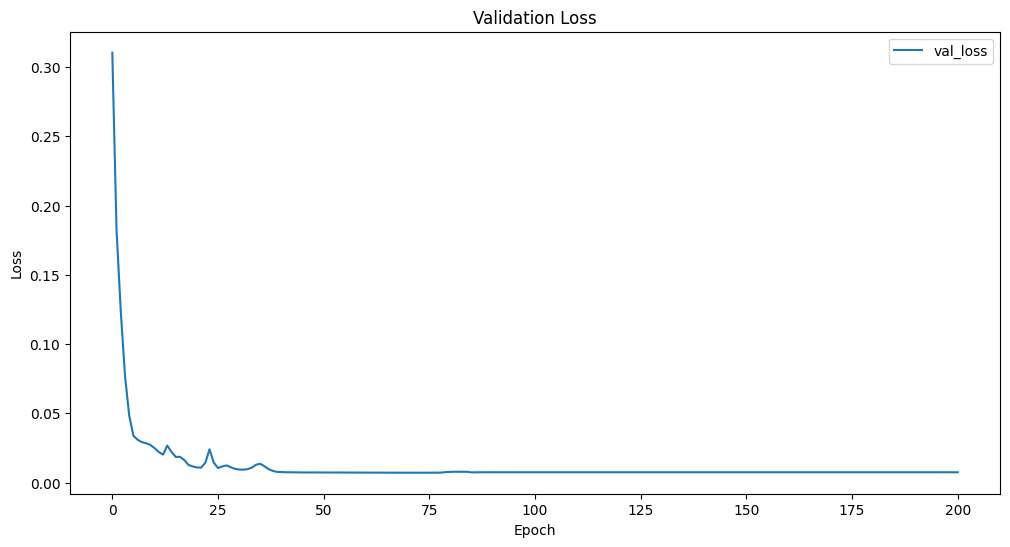

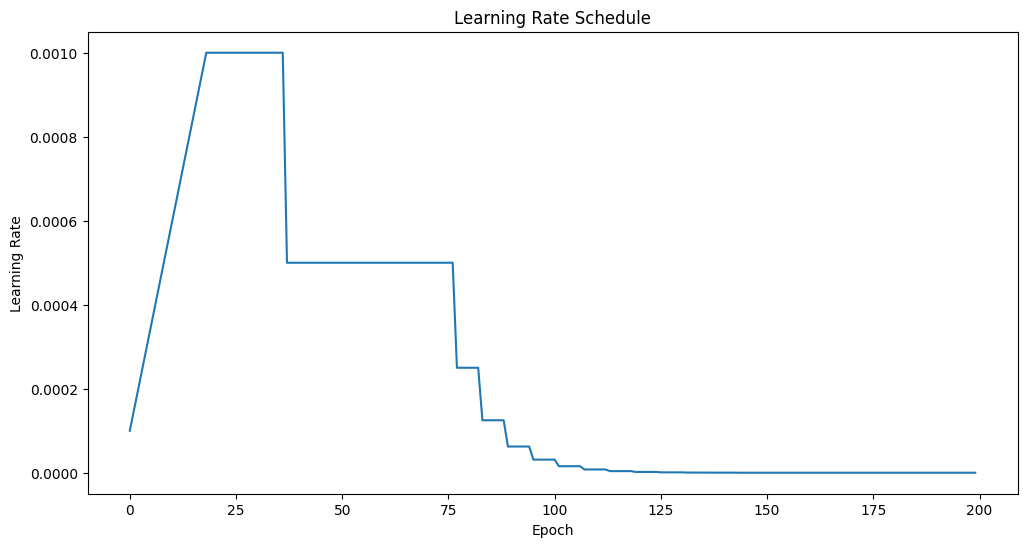

training model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.2848, val_loss: 0.3126
Epoch [1], last_lr: 0.00010, train_loss: 0.2089, val_loss: 0.1871
Epoch [2], last_lr: 0.00013, train_loss: 0.0783, val_loss: 0.1622
Epoch [3], last_lr: 0.00017, train_loss: 0.0661, val_loss: 0.1438
Epoch [4], last_lr: 0.00020, train_loss: 0.0546, val_loss: 0.1158
Epoch [5], last_lr: 0.00023, train_loss: 

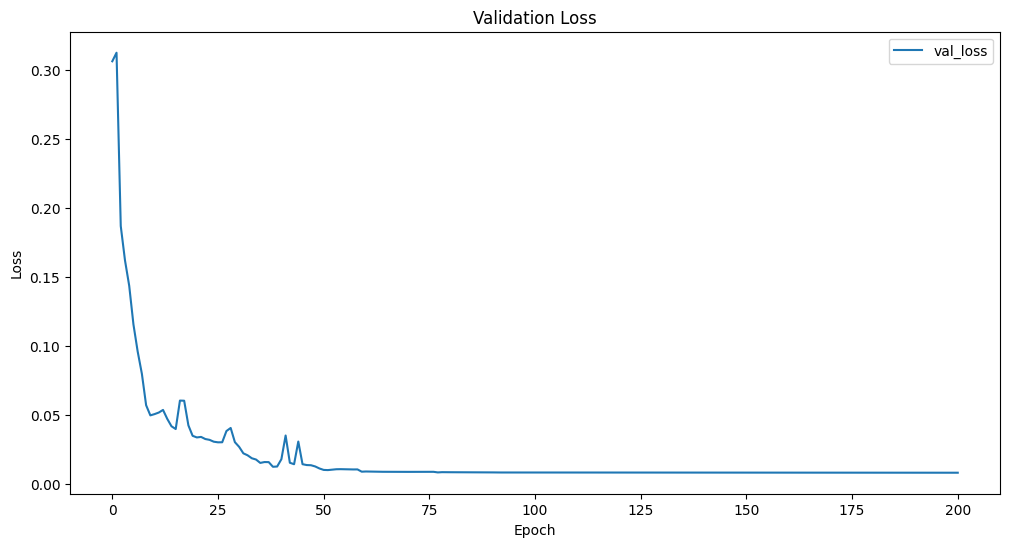

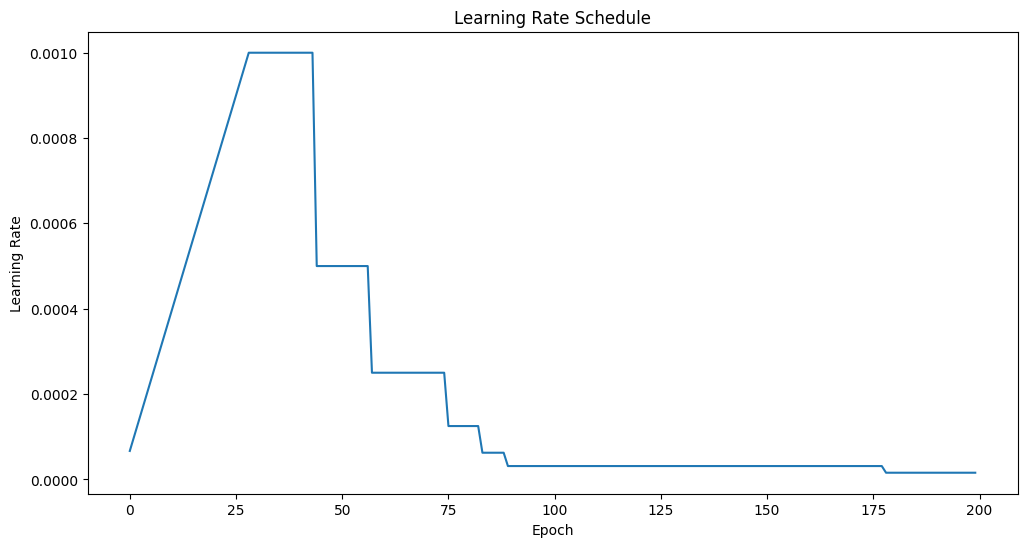

In [50]:
import time
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for model in models:
    print(f"training model: {model}")
    #evaluate untrained model
    history = [evaluate(model, test_loader)]

    #train model
    if (model == parallelCNNLSTM_model):
        epochs = 200
        warmup_epochs = 20
    elif (model == LSTM_model):
        epochs = 200
        warmup_epochs = 30
    elif(model == CNN_model):
        epochs = 200
        warmup_epochs = 40
    elif(model ==LSTM_CNN_model):
        warmup_epochs = 30
        epochs = 200

    max_lr = 0.001
    grad_clip = None
    weight_decay = 1e-5
    opt_func = torch.optim.Adam


    start_time = time.time()
    history += fit(epochs, max_lr, model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")

    #visualize val_loss
    plt.figure(figsize=(12, 6))
    val_loss = [x['val_loss'] for x in history]
    # train_loss = [x['train_loss'] for x in history[1:]]
    plt.plot(val_loss)
    # plt.plot(train_loss)
    plt.legend(['val_loss', 'train_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()


    plt.figure(figsize=(12, 6))
    lr = [x['lrs'] for x in history[1:]]
    plt.plot(lr)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

training model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.6700, val_loss: 1.7655
Epoch [1], last_lr: 0.00010, train_loss: 0.6608, val_loss: 1.7015
Epoch [2], last_lr: 0.00013, train_loss: 0.3837, val_loss: 0.6935
Epoch [3], last_lr: 0.00017, train_loss: 0.1253, val_loss: 0.5237
Epoch [4], last_lr: 0.00020, train_loss: 0.1926, val_loss: 0.6304
Epoch [5], last_lr: 0.00023, train_loss: 0.1564, val_loss: 0.5785
Epoch [6], last_lr: 0.00027, train_loss: 0.1073, val_loss: 0.4519
Epoch [7], last_lr: 0.00030, train_loss: 0.1142, val_loss: 0.4365
Epoch [8], last_lr: 0.00033, train_loss: 0.1379, val_loss: 0.4816
Epoch [9], last_lr: 0.00037, train_loss: 0.0756, val_loss

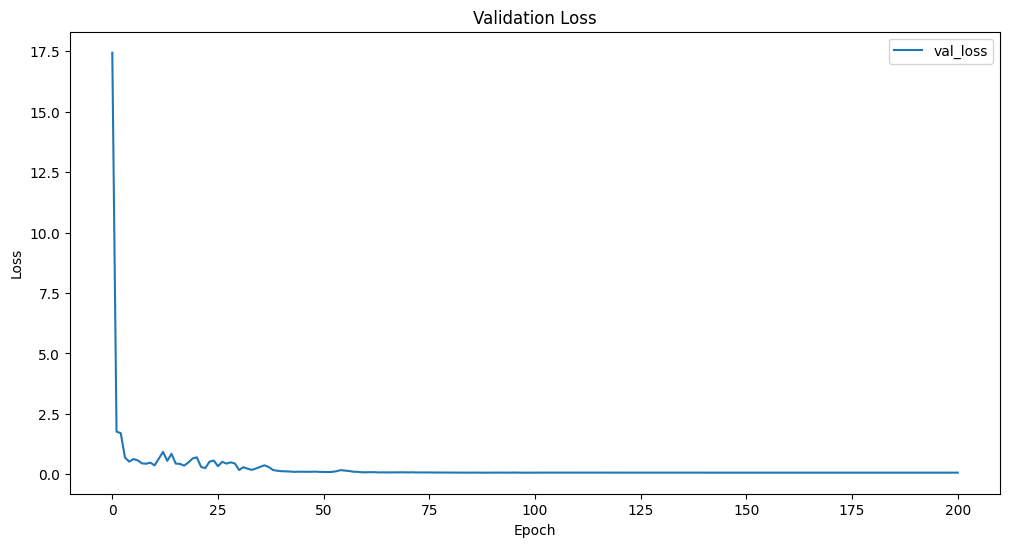

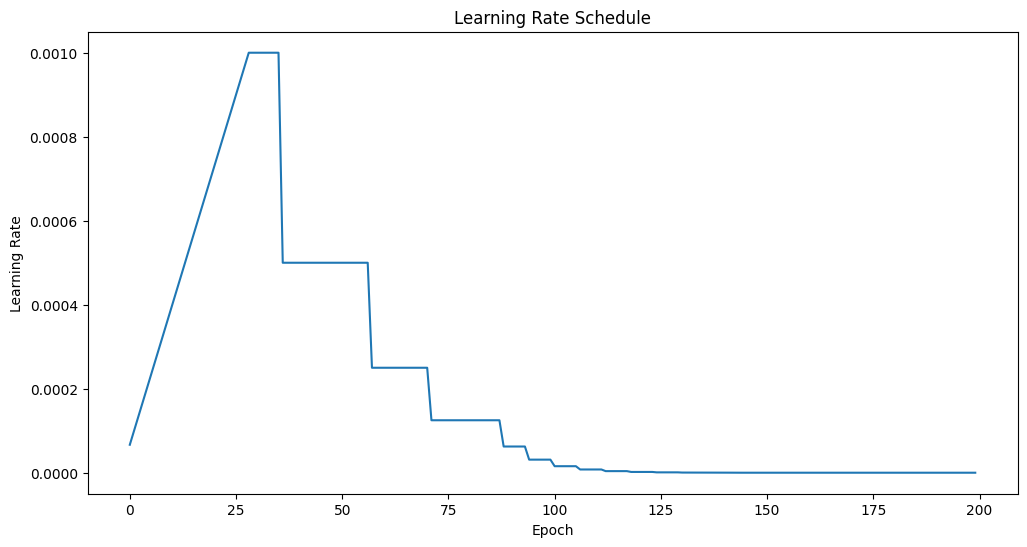

training model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00005, train_loss: 0.6324, val_loss: 1.5555
Epoch [1], last_lr: 0.00007, train_loss: 0.5341, val_loss: 1.2428
Epoch [2], last_lr: 0.00010, train_loss: 0.3831, val_loss: 0.8158
Epoch [3], last_lr: 0.00013, train_loss: 0.1903, val_loss: 0.3553
Epoch [4], last_lr: 0.00015, train_loss: 0.0606, val_loss: 0.2094
Epoch [5], last_lr: 0.00017, train_loss: 0.0400, val_loss: 0.1873
Epoch [6], last_lr: 0.00

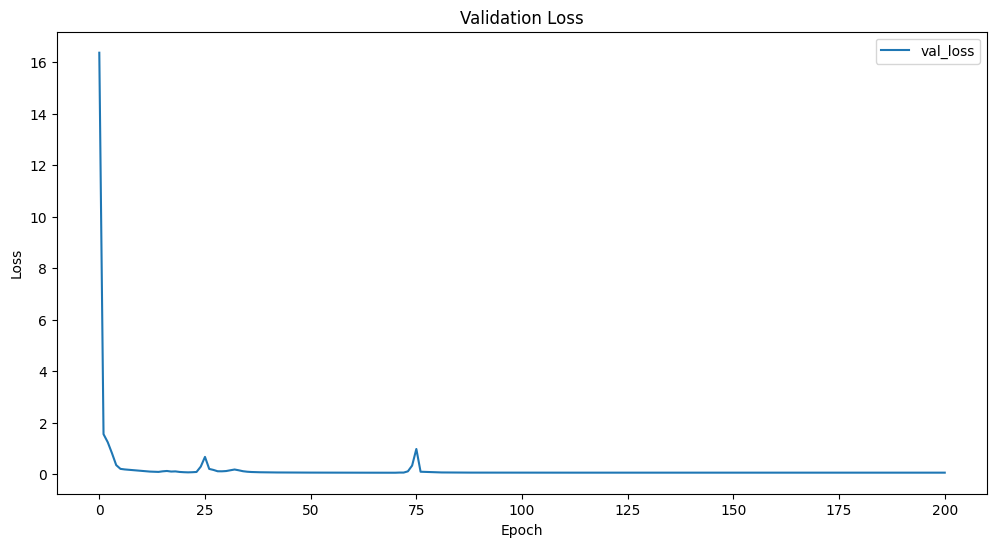

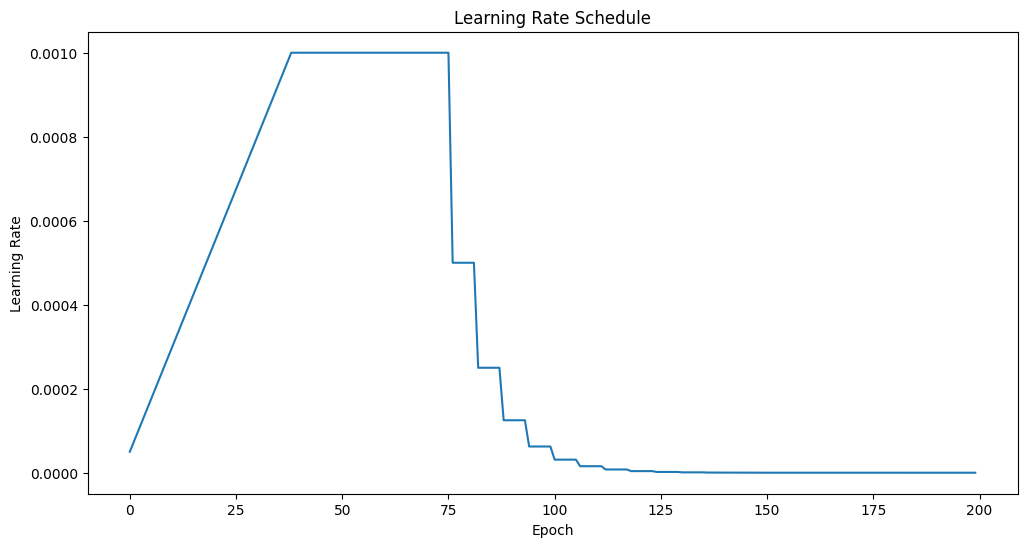

training model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)
warmup phase
Epoch [0], last_lr: 0.00010, train_loss: 0.5891, val_loss: 1.4161
Epoch [1], last_lr: 0.00015, train_loss: 0.3435, val_loss: 0.4682
Epoch [2], last_lr: 0.00020, train_loss: 0.2247, val_loss: 0.5170
Epoch [3], last_lr: 0.00025, train_loss: 0.0712, val_loss: 0.1972
Epoch [4], last_lr: 0.00030, train_l

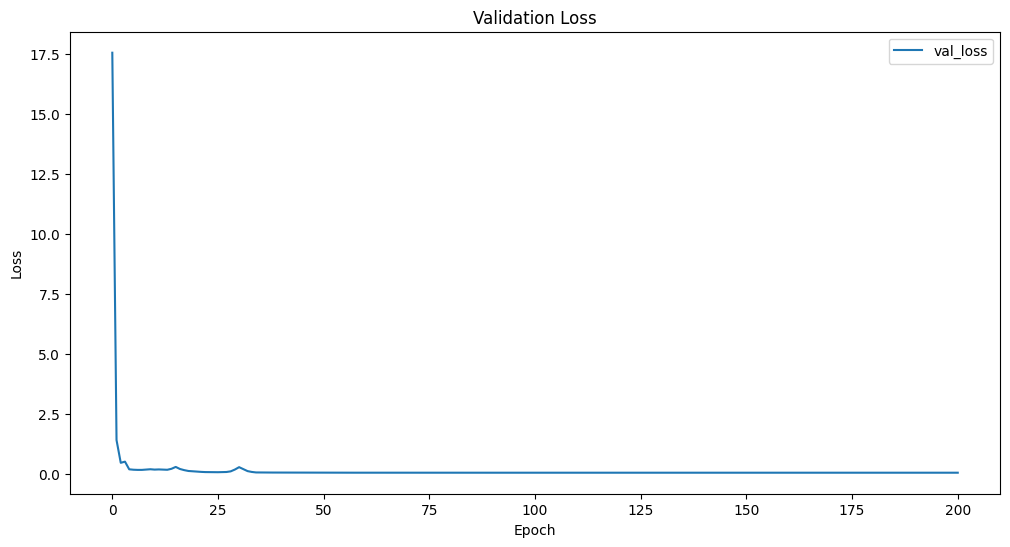

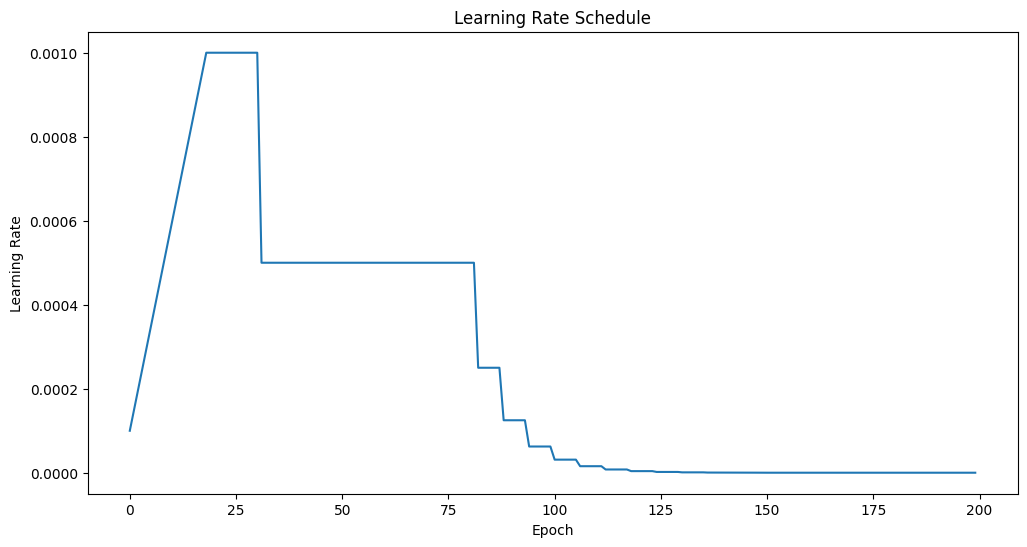

training model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): LazyLinear(in_features=0, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)
warmup phase
Epoch [0], last_lr: 0.00007, train_loss: 0.6826, val_loss: 1.8086
Epoch [1], last_lr: 0.00010, train_loss: 0.6638, val_loss: 1.7303
Epoch [2], last_lr: 0.00013, train_loss: 0.4617, val_loss: 0.5685
Epoch [3], last_lr: 0.00017, train_loss: 0.2669, val_loss: 0.7976
Epoch [4], last_lr: 0.00020, train_loss: 0.1448, val_loss: 0.4549
Epoch [5], last_lr: 0.00023, train_loss: 

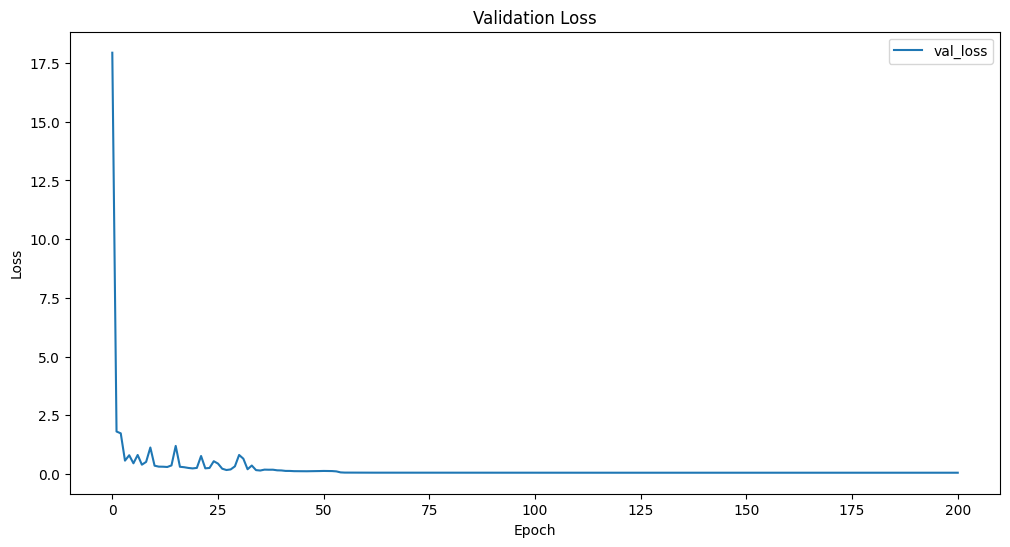

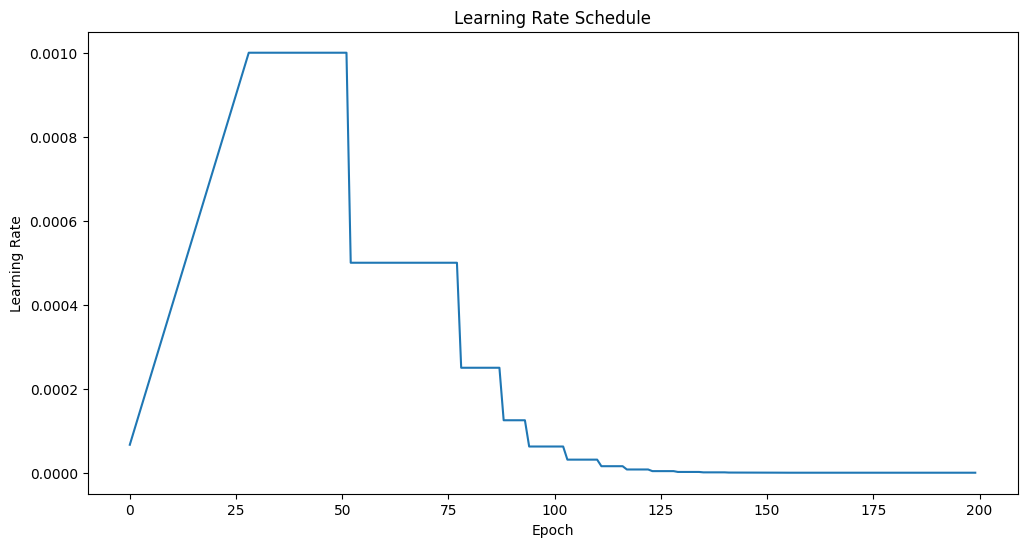

In [13]:
import time
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]

for model in models:
    print(f"training model: {model}")
    #evaluate untrained model
    history = [evaluate(model, test_loader)]

    #train model
    if (model == parallelCNNLSTM_model):
        epochs = 200
        warmup_epochs = 20
    elif (model == LSTM_model):
        epochs = 200
        warmup_epochs = 30
    elif(model == CNN_model):
        epochs = 200
        warmup_epochs = 40
    elif(model ==LSTM_CNN_model):
        warmup_epochs = 30
        epochs = 200

    max_lr = 0.001
    grad_clip = None
    weight_decay = 1e-5
    opt_func = torch.optim.Adam


    start_time = time.time()
    history += fit(epochs, max_lr, model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")

    #visualize val_loss
    plt.figure(figsize=(12, 6))
    val_loss = [x['val_loss'] for x in history]
    # train_loss = [x['train_loss'] for x in history[1:]]
    plt.plot(val_loss)
    # plt.plot(train_loss)
    plt.legend(['val_loss', 'train_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.show()


    plt.figure(figsize=(12, 6))
    lr = [x['lrs'] for x in history[1:]]
    plt.plot(lr)
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

##Save models state dict

In [51]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istances

for model in models:
    model_name = model.__class__.__name__
    save_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

    #save state dict of the model
    torch.save(model.state_dict(), save_path)

Mounted at /content/drive


Load models

In [10]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

model_names = ['LSTM', 'CNN', 'ParallelCNN_LSTM', 'LSTM_CNN']
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces


for model_name, model_istance in zip(model_names, models):
    model_path = f'/content/drive/MyDrive/università/Tesi/models/{model_name}'

   #load state dict
    model_istance.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Mounted at /content/drive


<ipython-input-10-5d20d59d2c28>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_istance.load_state_dict(torch.load(model_path, map_location=torch.device(device)))


##Batch inference

In [14]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

RobustScaler

model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


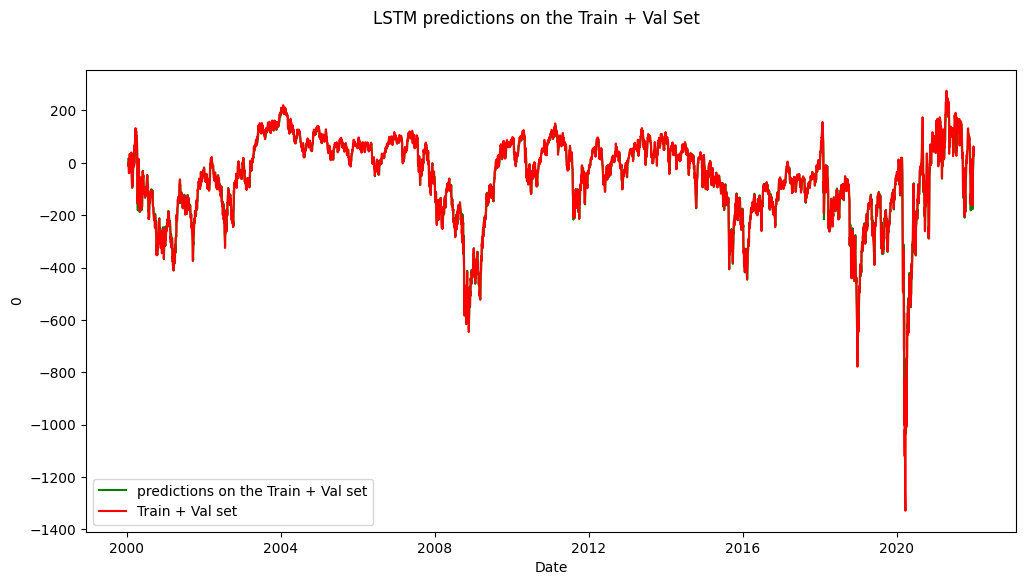

MSE: 548.0729282278588
RMSE: 23.410957439367124
MAE: 14.4496280656337
R2: 0.9787176589869915


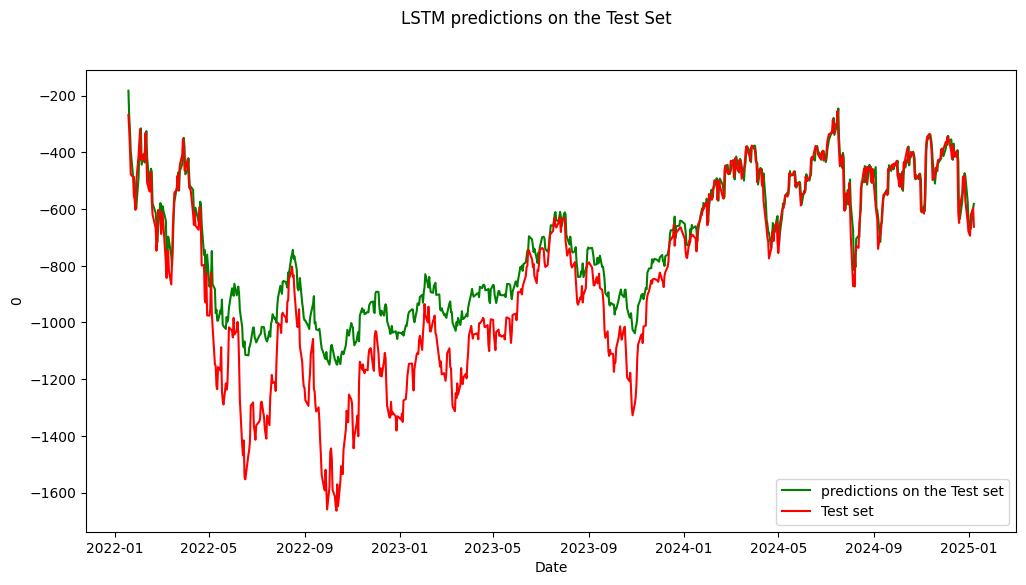

MSE: 25183.20672976675
RMSE: 158.6921760193827
MAE: 114.10953802069882
R2: 0.7732589118835842
model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


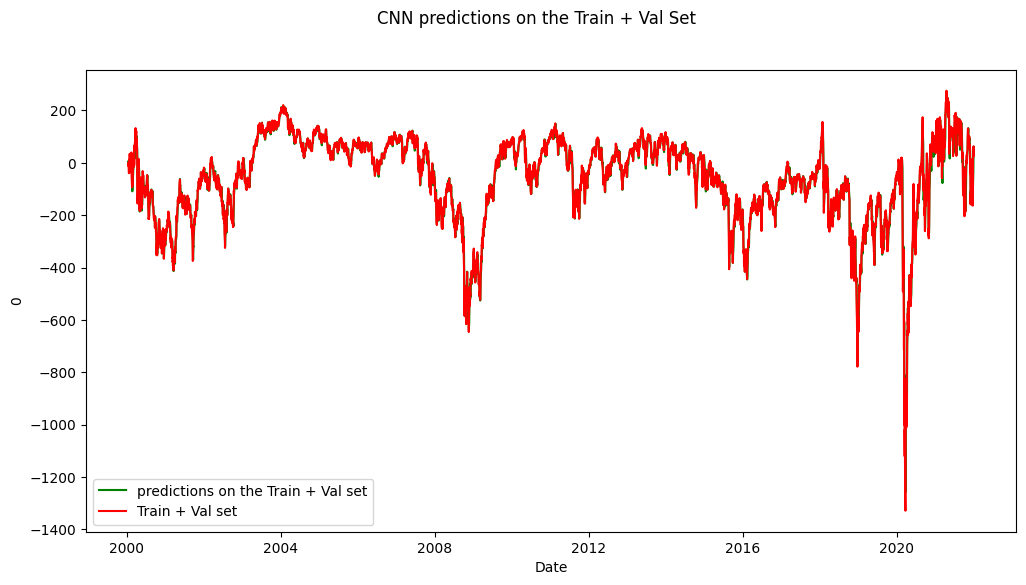

MSE: 563.2794788583549
RMSE: 23.733509619488537
MAE: 15.051219739391284
R2: 0.9781271700584537


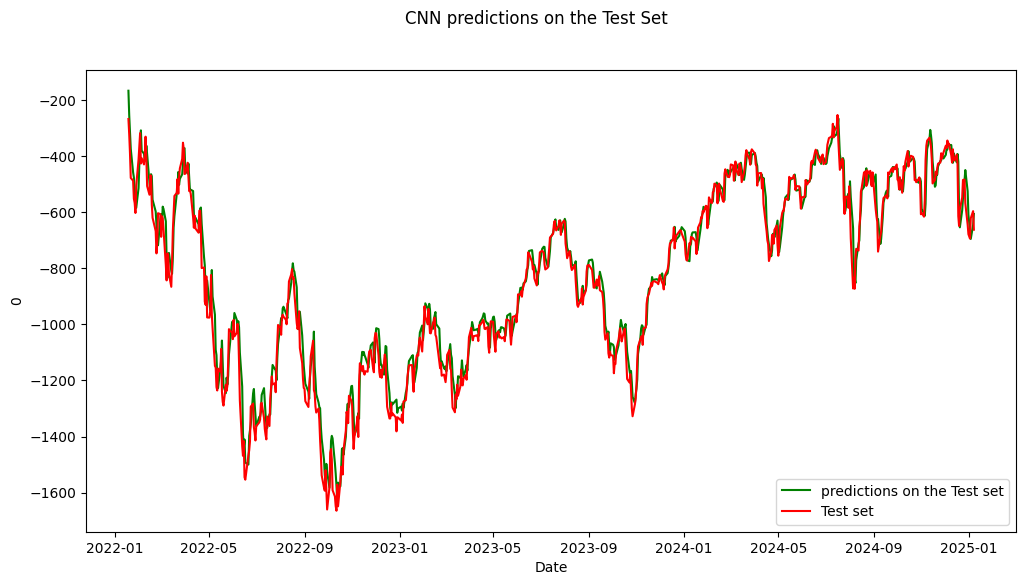

MSE: 3169.7514986589463
RMSE: 56.300546166613216
MAE: 42.82078798897087
R2: 0.9714606280456315
model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


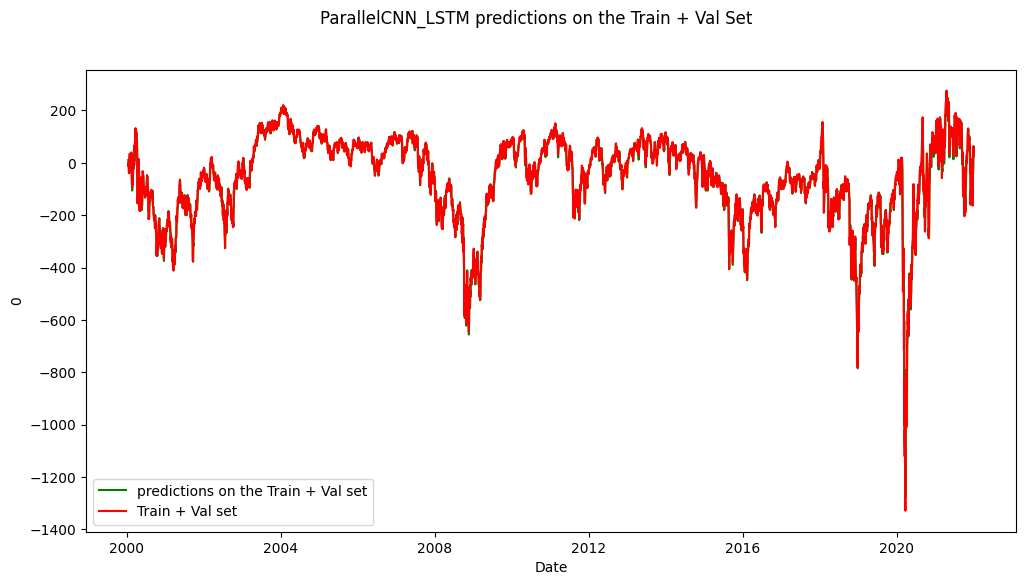

MSE: 501.3226435399521
RMSE: 22.39023545074844
MAE: 14.043764533695121
R2: 0.9805330296246187


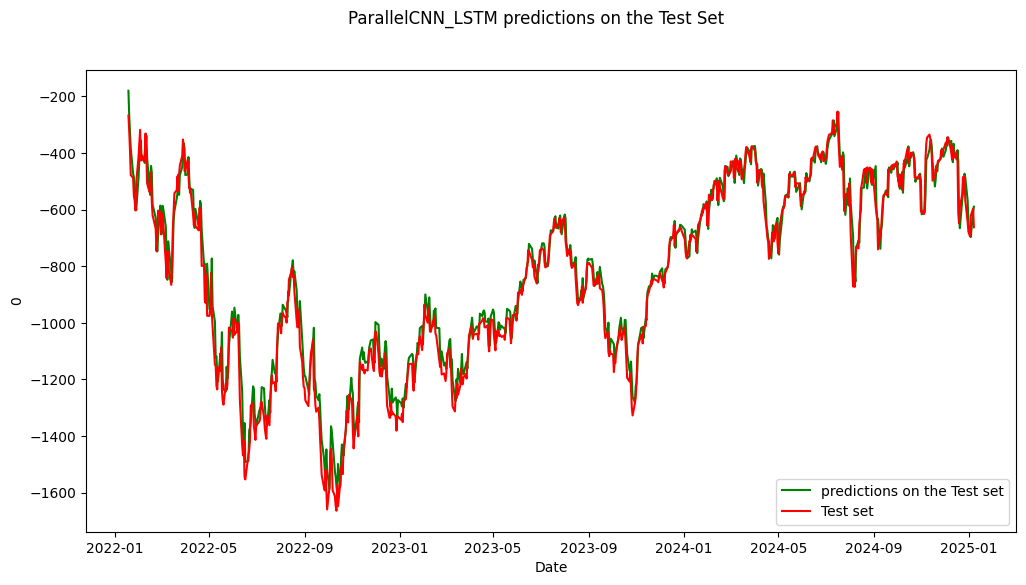

MSE: 3051.1574408524843
RMSE: 55.23728306906925
MAE: 42.22205510540786
R2: 0.9725284088886246
model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


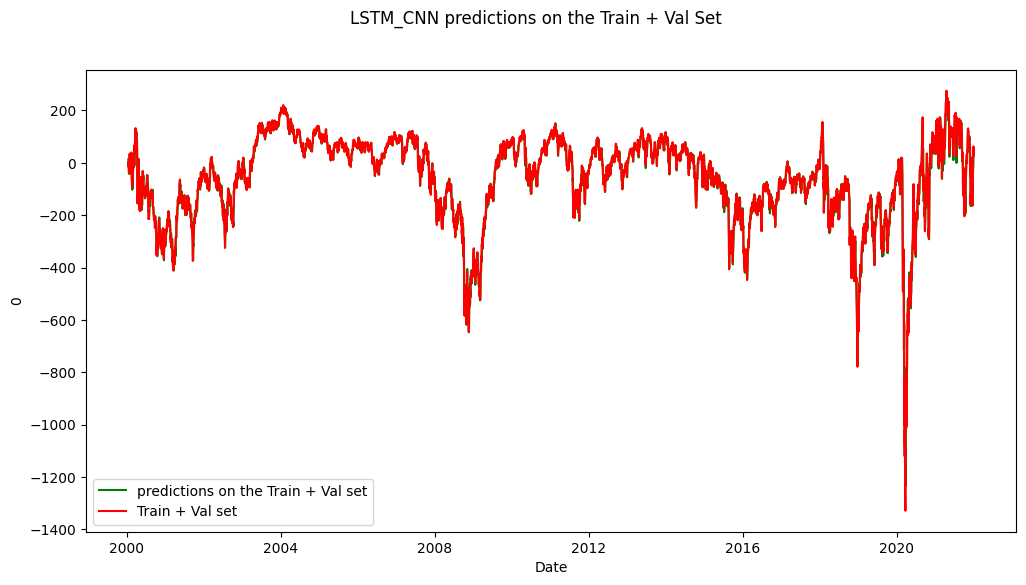

MSE: 484.2642911034119
RMSE: 22.006005796223263
MAE: 13.893096240627965
R2: 0.9811954262783786


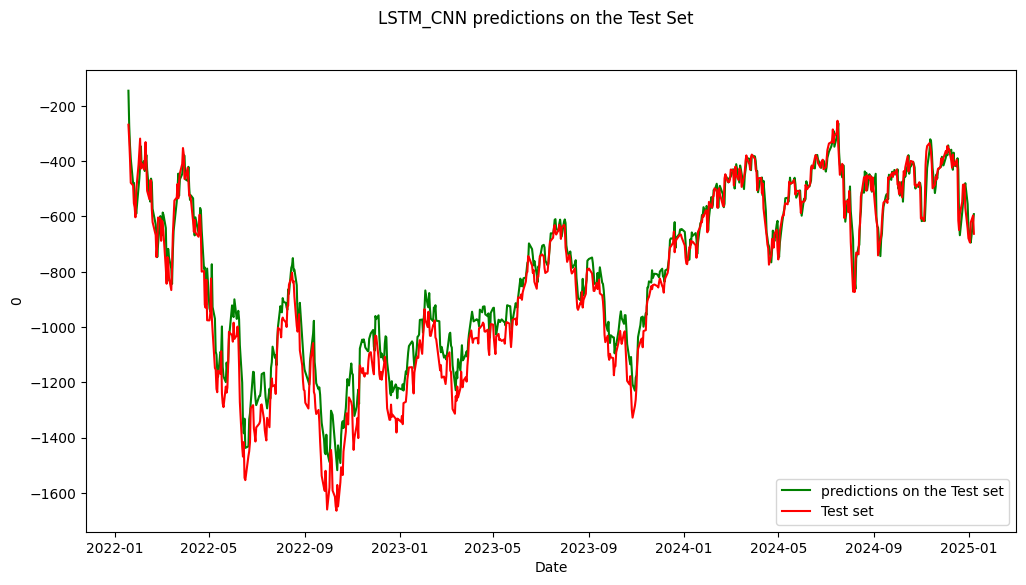

MSE: 5867.633269756507
RMSE: 76.60047826062515
MAE: 59.26120288329478
R2: 0.9471698117507772


In [15]:
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]
for model in models:
    print(f"model: {model}")
    model_name = model.__class__.__name__
    #batch inference
    prediction, actual = inference(model, test_loader)

    ## Inverse Scale
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(actual)


    #predictions on the test_loader
    prediction = pd.DataFrame(prediction)
    prediction.index = test_data[10:].index
    actual = pd.DataFrame(actual)
    actual.index = test_data[10:].index


    #predictions on the train_val_loader
    train_predictions, actual_train = inference(model, train_val_loader)

    ## Inverse Scale
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)

    train_predictions = pd.DataFrame(train_predictions)
    train_predictions.index = train_val_data[10:].index
    actual_train = pd.DataFrame(actual_train)
    actual_train.index = train_val_data[10:].index


    #visualize
    #predictions on the train + val set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions on the Train + Val set")
    sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train + Val set")
    plt.suptitle(f'{model_name} predictions on the Train + Val Set')
    plt.show()


    #compute metrics
    mse = mean_squared_error(actual_train, train_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_train, train_predictions)
    r2 = r2_score(actual_train, train_predictions)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")


    #predictions on the Test set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions on the Test set")
    sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "Test set")
    plt.suptitle(f'{model_name} predictions on the Test Set')
    plt.show()


    #compute metrics
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, prediction)
    r2 = r2_score(actual, prediction)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")

MinMax scaler

model: LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


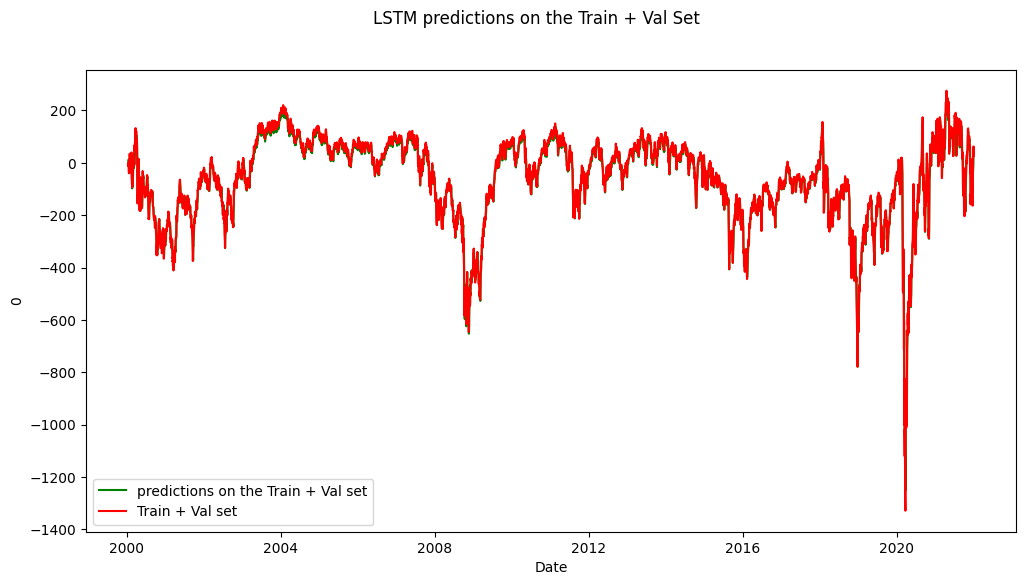

MSE: 515.8822108259739
RMSE: 22.713040545597895
MAE: 15.589240256091541
R2: 0.979967663890262


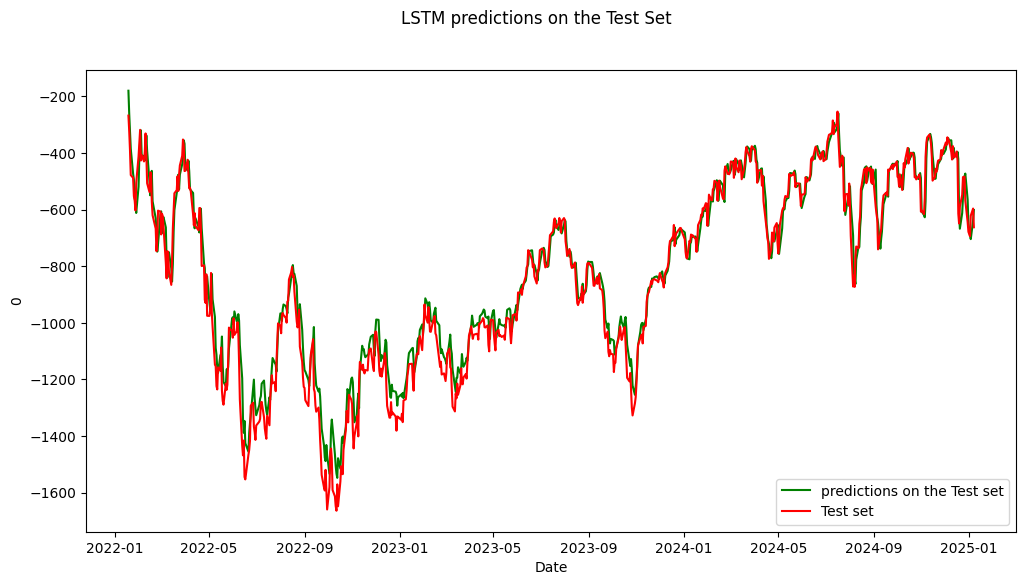

MSE: 3919.135708960743
RMSE: 62.603000798370225
MAE: 46.9569044055443
R2: 0.9647134255344537
model: CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


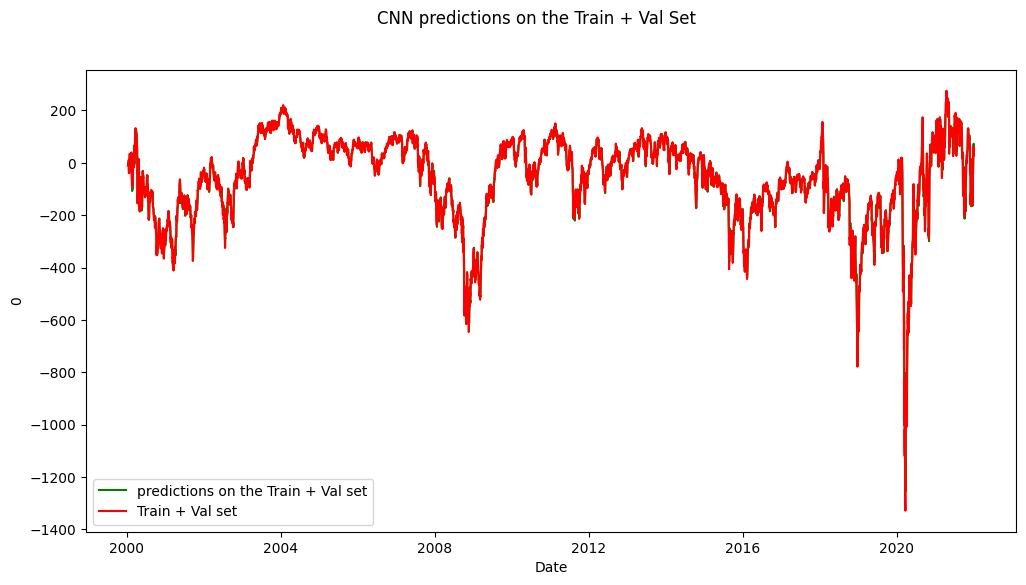

MSE: 536.465333435739
RMSE: 23.161721296910102
MAE: 14.498832151932946
R2: 0.9791683961084818


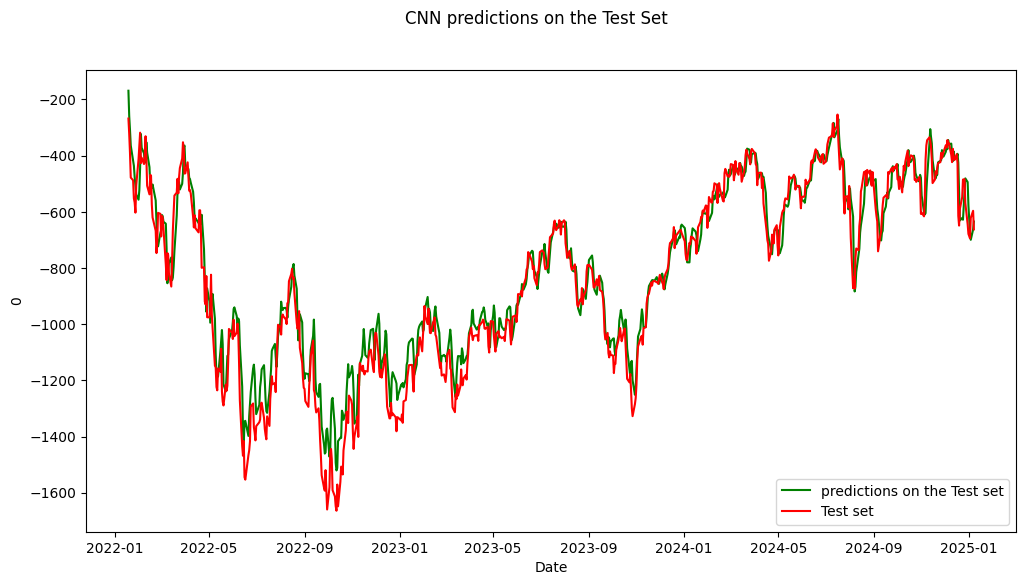

MSE: 6196.731359217628
RMSE: 78.71932011404587
MAE: 58.85347283418469
R2: 0.9442067234237208
model: ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


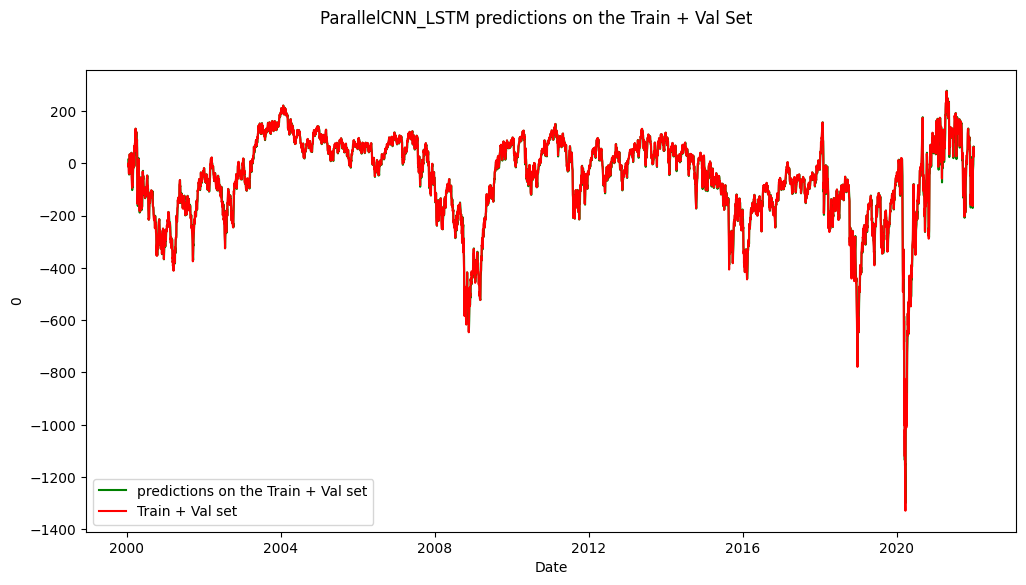

MSE: 476.10392708560056
RMSE: 21.819805844360772
MAE: 13.777153898904274
R2: 0.9815123032149634


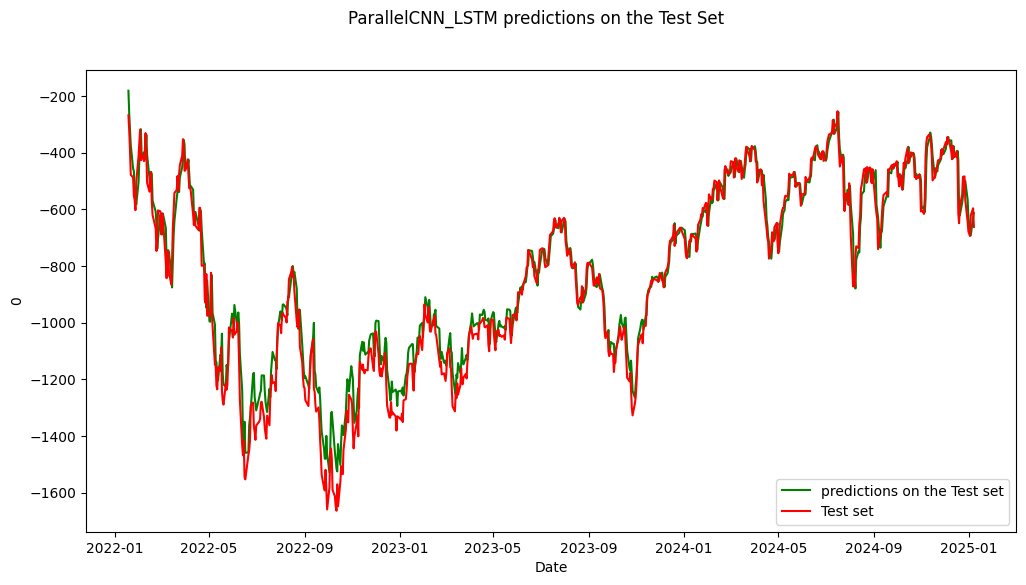

MSE: 4003.6476405529243
RMSE: 63.27438376272759
MAE: 47.60454168178362
R2: 0.9639525086413396
model: LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


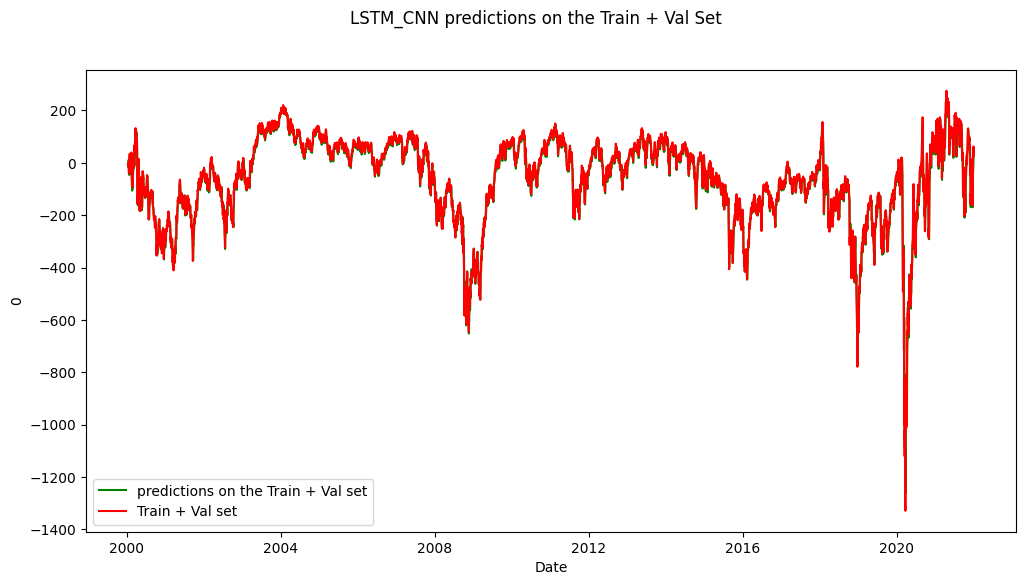

MSE: 510.24562359121376
RMSE: 22.588617124366284
MAE: 14.846604516480536
R2: 0.9801865394545459


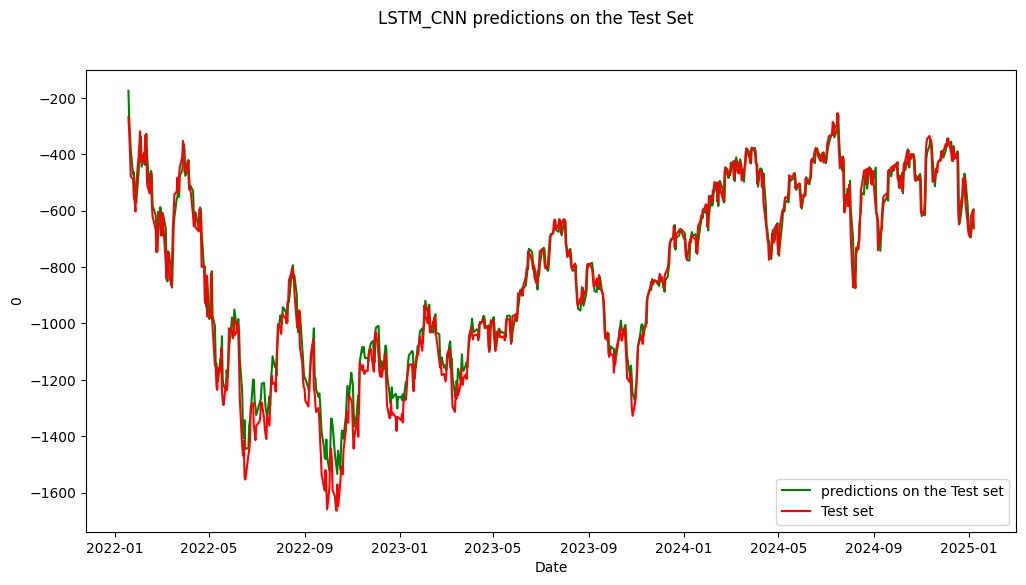

MSE: 3389.1125178777106
RMSE: 58.21608470068827
MAE: 43.579771071476394
R2: 0.9694855753627579


In [53]:
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model]
for model in models:
    print(f"model: {model}")
    model_name = model.__class__.__name__
    #batch inference
    prediction, actual = inference(model, test_loader)

    ## Inverse Scale
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(actual)


    #predictions on the test_loader
    prediction = pd.DataFrame(prediction)
    prediction.index = test_data[10:].index
    actual = pd.DataFrame(actual)
    actual.index = test_data[10:].index


    #predictions on the train_val_loader
    train_predictions, actual_train = inference(model, train_val_loader)

    ## Inverse Scale
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)

    train_predictions = pd.DataFrame(train_predictions)
    train_predictions.index = train_val_data[10:].index
    actual_train = pd.DataFrame(actual_train)
    actual_train.index = train_val_data[10:].index


    #visualize
    #predictions on the train + val set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions on the Train + Val set")
    sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train + Val set")
    plt.suptitle(f'{model_name} predictions on the Train + Val Set')
    plt.show()


    #compute metrics
    mse = mean_squared_error(actual_train, train_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_train, train_predictions)
    r2 = r2_score(actual_train, train_predictions)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")


    #predictions on the Test set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions on the Test set")
    sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "Test set")
    plt.suptitle(f'{model_name} predictions on the Test Set')
    plt.show()


    #compute metrics
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, prediction)
    r2 = r2_score(actual, prediction)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")


##Combine ARIMA and NN predictions

LSTM(
  (lstm): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


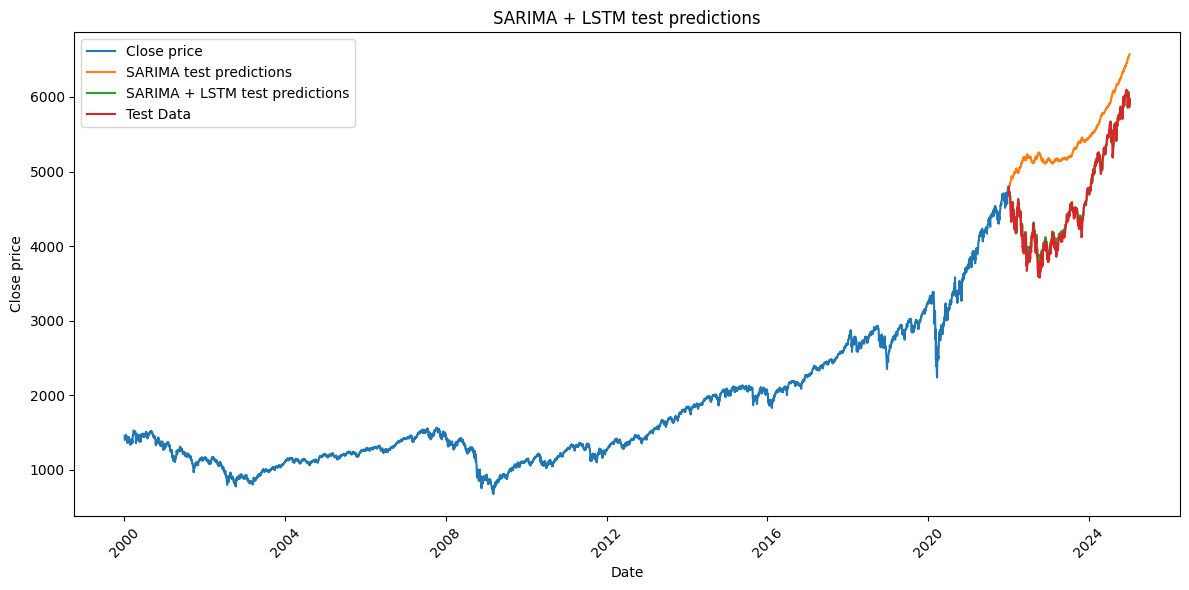

MSE: 3919.135708960743
RMSE: 62.603000798370225
MAE: 46.9569044055443
R2: 0.9647134255344537


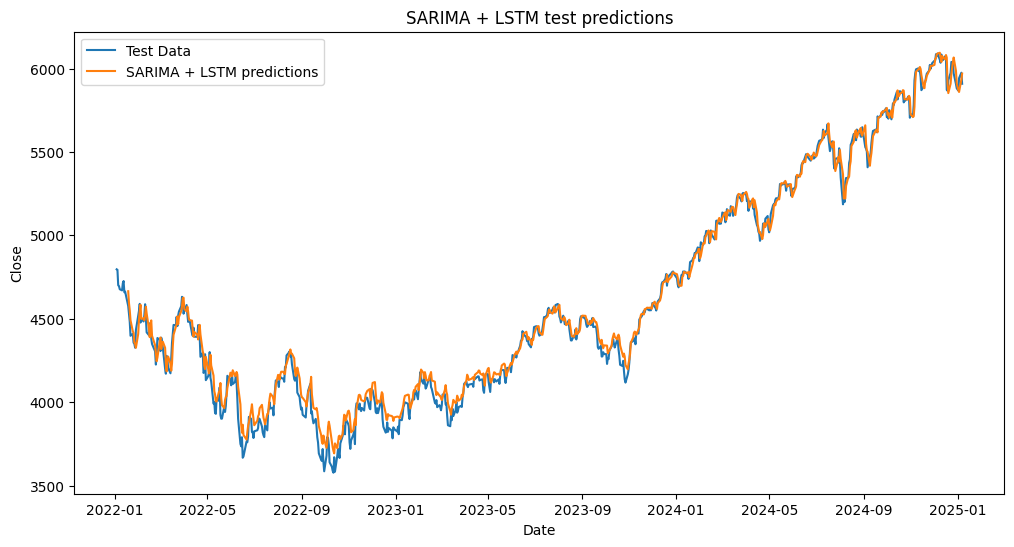

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
CNN(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


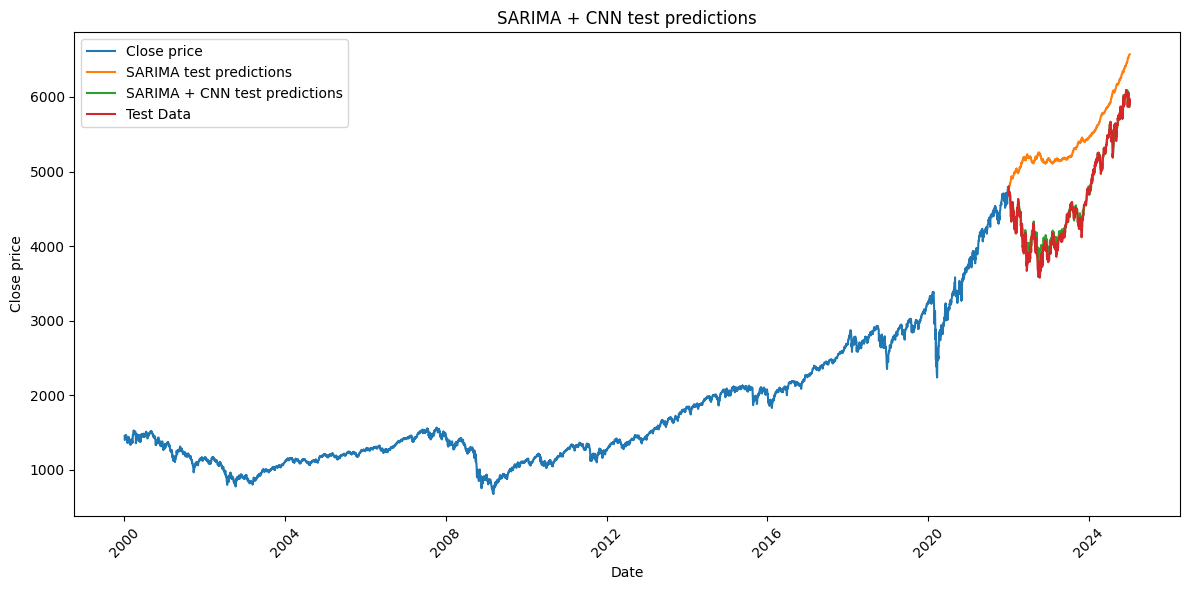

MSE: 6196.731359217628
RMSE: 78.71932011404587
MAE: 58.85347283418469
R2: 0.9442067234237208


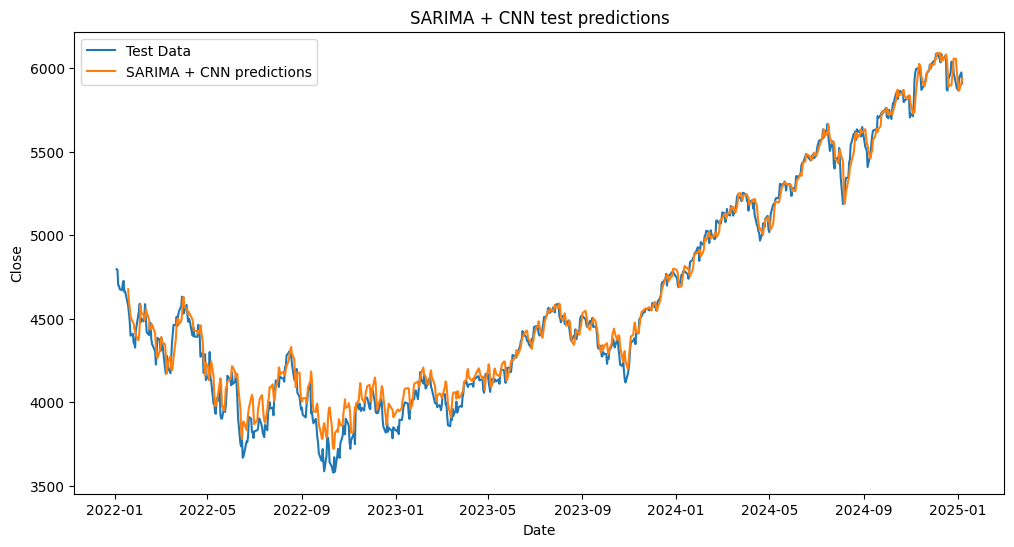

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ParallelCNN_LSTM(
  (cnn): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
  )
  (lstm): LSTM(1, 512, batch_first=True)
  (fc_lstm): Linear(in_features=512, out_features=128, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


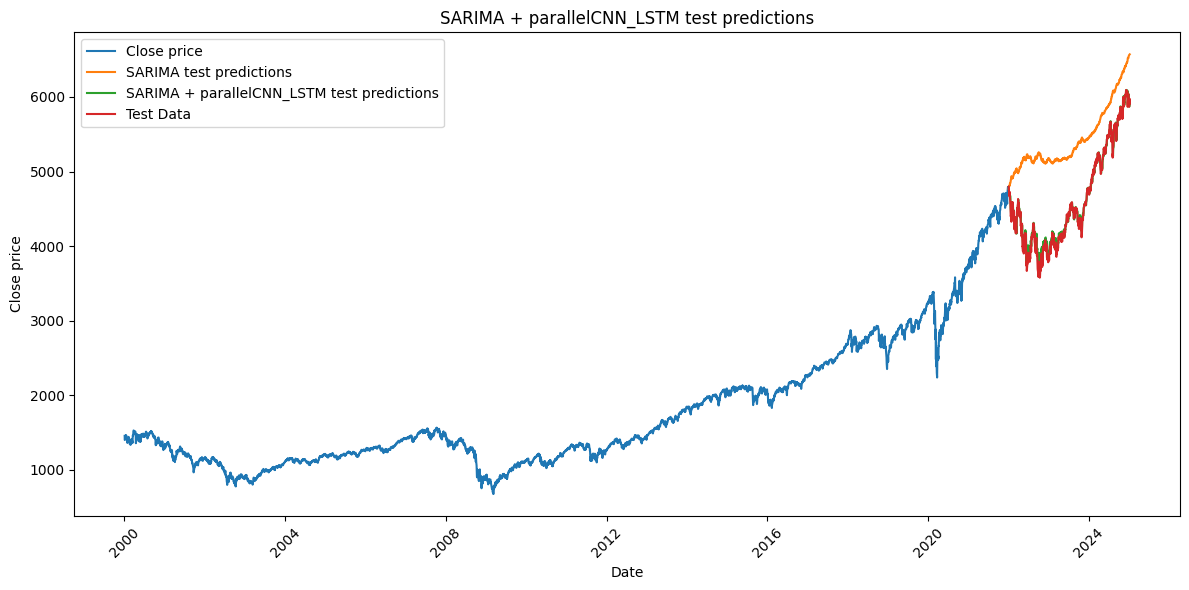

MSE: 4003.6476405529243
RMSE: 63.27438376272759
MAE: 47.60454168178362
R2: 0.9639525086413396


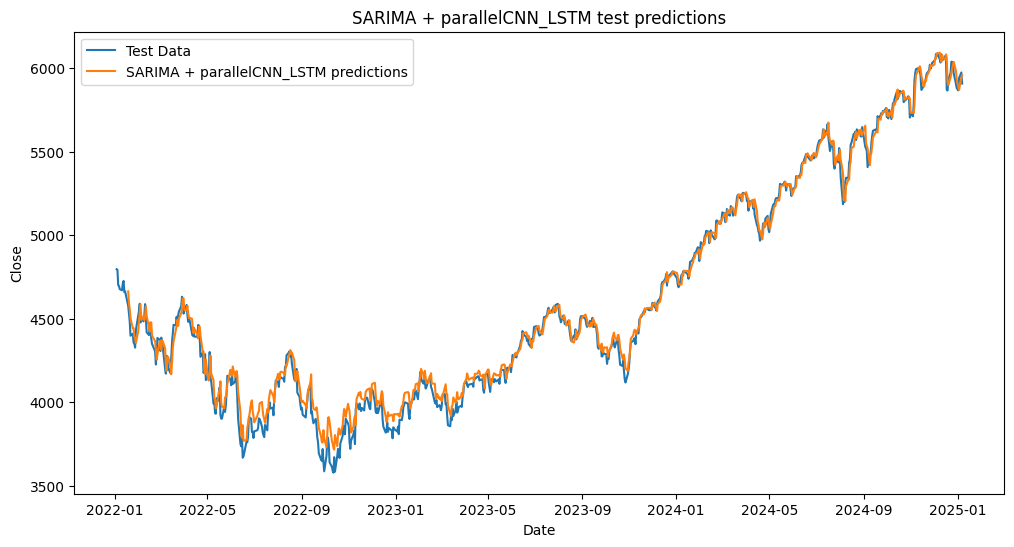

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
LSTM_CNN(
  (lstm): LSTM(1, 512, batch_first=True)
  (cnn): Sequential(
    (0): Conv1d(512, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=256, bias=True)
    (8): ReLU()
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)


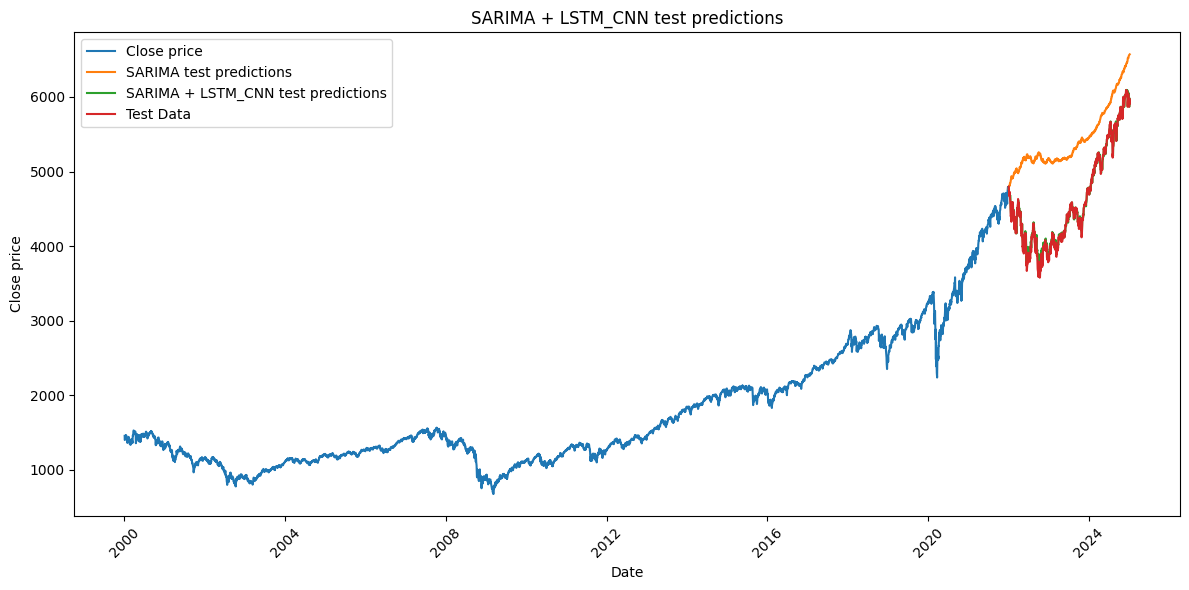

MSE: 3389.1125178777106
RMSE: 58.21608470068827
MAE: 43.579771071476394
R2: 0.9694855753627579


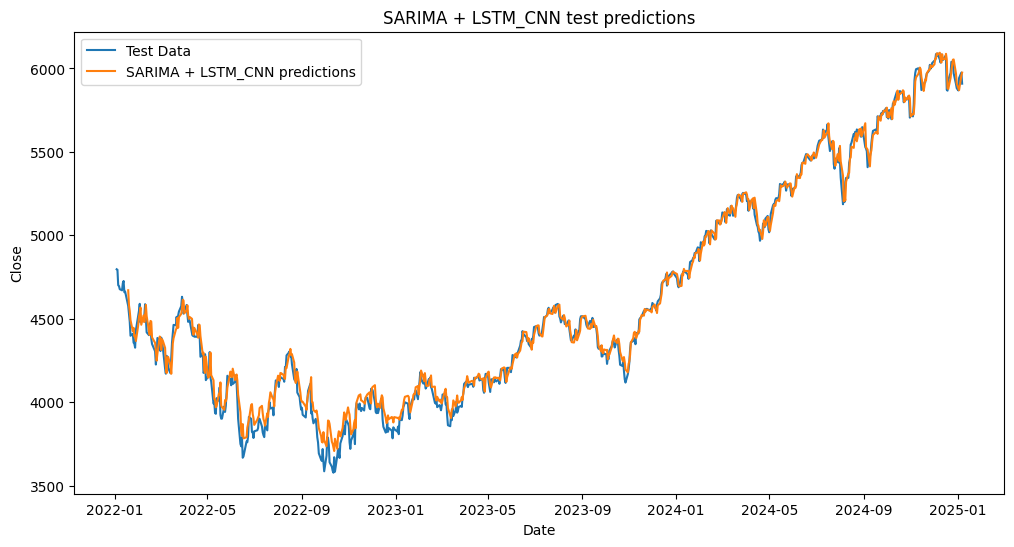

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
model_names = ['LSTM', 'CNN', 'parallelCNN_LSTM', 'LSTM_CNN'] #model names
models = [LSTM_model, CNN_model, parallelCNNLSTM_model, LSTM_CNN_model] #model istannces
for model_name, model in zip(model_names, models):
    print(model)
    #generate predictions
    prediction, actual = inference(model, test_loader)
    train_predictions, actual_train = inference(model, train_val_loader)

    #rescale predictions
    prediction = scaler.inverse_transform(prediction)
    actual = scaler.inverse_transform(actual)
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)

    #set index
    prediction = pd.DataFrame(prediction)
    prediction.index = test_data[10:].index
    actual = pd.DataFrame(actual)
    actual.index = test_data[10:].index

    train_predictions = pd.DataFrame(train_predictions)
    train_predictions.index = train_val_data[10:].index
    actual_train = pd.DataFrame(actual_train)
    actual_train.index = train_val_data[10:].index

    #combine arima and NN predictions on test set
    SARIMA_NN_test_predictions = SARIMA_test_predictions[10:] + prediction[0]

    #combine arima and NN predictions on train set
    SARIMA_NN_train_predictions = SARIMA_fitted_values.iloc[10:,0].values + train_predictions[0]


    #visualize
    # #predictions on train set
    # plt.figure(figsize=(12, 6))
    # # sns.lineplot(data = Close_price.loc[train_val_data.index], label="Close price")
    # sns.lineplot(x=train_val_data.index, y=SARIMA_fitted_values.values.ravel(), label="SARIMA fitted values")
    # # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
    # sns.lineplot(x=train_val_data.index[10:], y=SARIMA_fitted_values.iloc[10:,0], label="SARIMA + NN train predictions")
    # sns.lineplot(x=train_val_data.index, y=Close_price.loc[train_val_data.index ], label="Train + Val Data")
    # plt.title('SARIMA + XGBoost train predictions')
    # plt.xlabel('Date')
    # plt.ylabel('Close price')
    # plt.xticks(rotation=45)  # Rotate x-axis labels
    # plt.tight_layout() # Automatically adjusts the layout
    # plt.legend()
    # plt.show()


    # #compute metrics
    # mse = mean_squared_error(actual_train, train_predictions)
    # rmse = np.sqrt(mse)
    # mae = mean_absolute_error(actual_train, train_predictions)
    # r2 = r2_score(actual_train, train_predictions)

    # print(f"MSE: {mse}")
    # print(f"RMSE: {rmse}")
    # print(f"MAE: {mae}")
    # print(f"R2: {r2}")


    #predictions on test set
    plt.figure(figsize=(12, 6))
    sns.lineplot(data = Close_price.loc[train_val_data.index], label="Close price")
    sns.lineplot(x=test_data.index, y=SARIMA_test_predictions.values.ravel(), label="SARIMA test predictions")
    # sns.lineplot(x=test_data.index, y=XGBoost_predictions.values.ravel(), label="XGBoost predictions")
    sns.lineplot(x=test_data.index[10:], y=SARIMA_NN_test_predictions, label= f"SARIMA + {model_name} test predictions")
    sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
    plt.title(f'SARIMA + {model_name} test predictions')
    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(actual, prediction)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, prediction)
    r2 = r2_score(actual, prediction)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2: {r2}")


    #close up
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_data.index, y=Close_price.loc[test_data.index ], label="Test Data")
    sns.lineplot(x=test_data[10:].index, y=SARIMA_NN_test_predictions, label=f"SARIMA + {model_name} predictions")
    plt.title(f'SARIMA + {model_name} test predictions')
    plt.show()


    #save ARIMA + XGBoost predictions
    drive.mount('/content/gdrive')
    file_path = f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/CNN LSTM/SARIMA_{model_name}_predictions.csv'
    SARIMA_NN_test_predictions = pd.Series(SARIMA_NN_test_predictions, index=test_data.index)
    SARIMA_NN_test_predictions.to_csv(file_path, index=True)
